# Lab 6

**Joseph Livesey**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import random

from warnings import filterwarnings
filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16

In this lab, we will explore the mechanics of analyzing real-world data using a simulated background distribution and injected signals. Eventually, we will use this to analyze LHC data. Our first step is to create a fake background for the LHC data. We will use a Poisson distribution with $\lambda=100$.

In [2]:
bkgd = stats.poisson.rvs(mu=100, size=int(1e6))

## Problem 1

We want to find the $5\sigma$ confidence interval of the background. We do this by making a histogram and summing over the bins until we encounter the $-1\sigma$ and $+1\sigma$ cumulative probabilities.

In [3]:
density, counts = np.histogram(bkgd, bins=30)

prob = [density[i] * counts[i] for i in range(len(density))]
prob = prob / sum(prob)

prob_5s = stats.norm.cdf(5.0)

cdf = 0.0
in_low_tail = True

for i in range(len(prob)):
    cdf += prob[i]
    if in_low_tail == True and cdf >= 1 - prob_5s:
        in_low_tail = False
        minus_5s = counts[i]
        print(counts[i])
    if cdf >= prob_5s:
        plus_5s = counts[i]
        print(counts[i])
        break

57.0
144.96666666666667


The limits of our confidence interval are 56.0 and 144.9 particle counts. As expected, the interval is roughly symmetric around a background value of 100 counts.

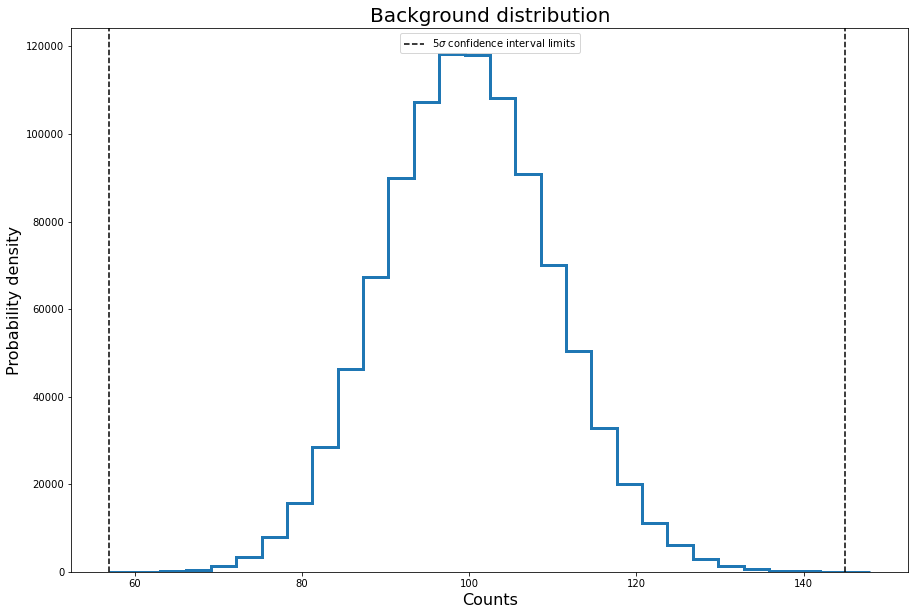

In [4]:
fig, ax = plt.subplots(1, 1)
# ax.hist(bkgd, bins=25, density=True)
ax.stairs(density, counts, lw=3)
ax.axvline(minus_5s, c='k', ls='--', label=r'$5\sigma$ confidence interval limits')
ax.axvline(plus_5s, c='k', ls='--')
ax.set_title('Background distribution')
ax.set_xlabel('Counts')
ax.set_ylabel('Probability density')
ax.legend(loc=0);

## Problem 2

We want to inject a signal of decent strength in our data. Let's use a signal of strength 250, well above the $8\sigma$ limit of $\sim 190$ counts.

In [5]:
stats.poisson.cdf(189.0, mu=100.0), stats.norm.cdf(8.0)

(0.9999999999999992, 0.9999999999999993)

We inject this signal multiple times into the background to create our toy data set.

In [6]:
data = bkgd + 250.0

### Part (a)

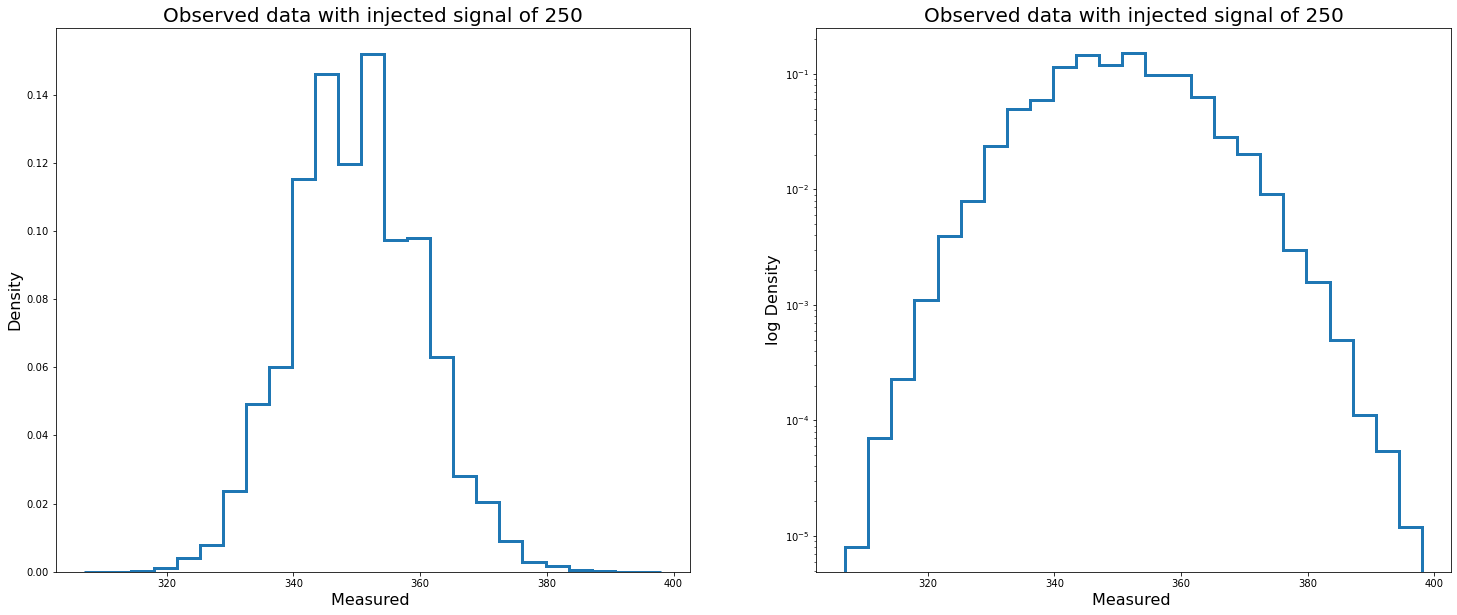

In [7]:
stairs, edges = np.histogram(data, bins=25)

fig, axes = plt.subplots(1, 2, figsize=(25, 10))
for ax in axes:
    ax.stairs(stairs/sum(stairs), edges, lw=3)
    ax.set_title('Observed data with injected signal of 250')
    ax.set_xlabel('Measured ')
axes[1].set_yscale('log')
axes[0].set_ylabel('Density')
axes[1].set_ylabel('log Density');

The histogram tells us that if we inject a signal of magnitude 250 into our data, we will measure a signal that is significantly greater (by 100, on average, since this is the expectation value of our Poissonian background distribution). It also tells us that we have a high probability of measuring a spread of values; there is nonzero dispersion in the data despite the fact that we injected *only* signals of exactly 250.

### Part (b)

It is very unlikely to measure the value of our injected signal. This is because the background is biased (with an average additive influence of 100). We can see clearly on the logarithmic plot above that the distribution we get is asymmetric—skewed to the right. This is to be expected, since our background is Poisson-distributed, so it has a larger tail at the higher end.

## Problem 3
### Part (a)

Here, we want to create a suite of histograms of the measured data distribution when we inject signals within a range of intensities, and then compile a 2D histogram from these. Stated another way, we are plotting $P(D|S)$ vs. $P(S|D)$, with $S$ the signals and $D$ the observed data.

In [8]:
sig  = stats.uniform.rvs(loc=0., scale=350., size=int(1e6))
data = bkgd + sig

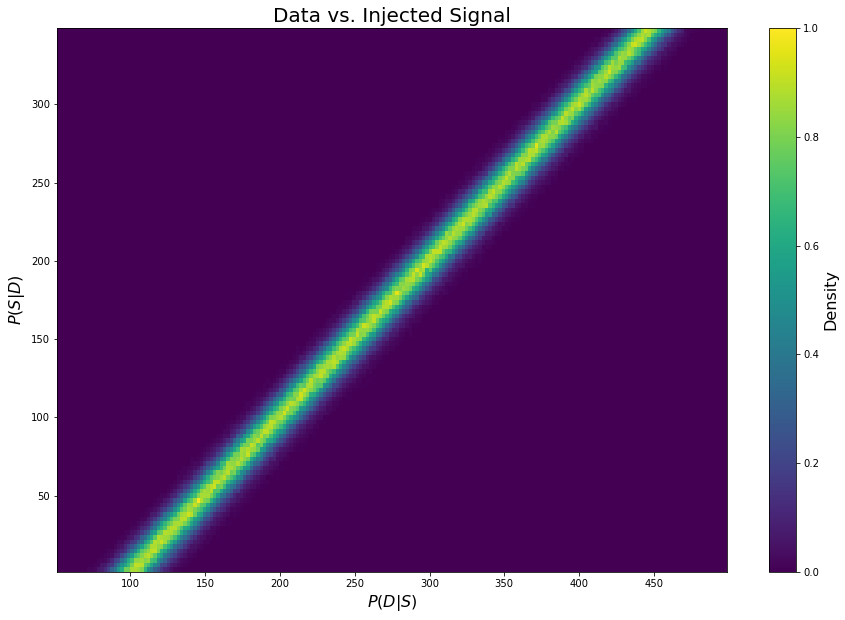

In [9]:
signaledges = np.linspace(0, 350, 120)
dataedges = np.linspace(50, 500, 204)

Psd, temp, temp2 = np.histogram2d(data, sig, bins=[dataedges, signaledges], density=True)

datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2

plt.pcolormesh(datacenters, signalcenters, Psd.T)
plt.title('Data vs. Injected Signal')
plt.ylabel(r'$P(S|D)$')
plt.xlabel(r'$P(D|S)$')
plt.colorbar(plt.cm.ScalarMappable(), label='Density');

The distribution of measured data at every intensity of the injected signal looks roughly Gaussian, but this is to be expected, since the Poisson distribution approaches a Gaussian distribution asymptotically at large expected values. For comparison, we will now make the histogram of $P(D|S=250)$.

### Part (b)

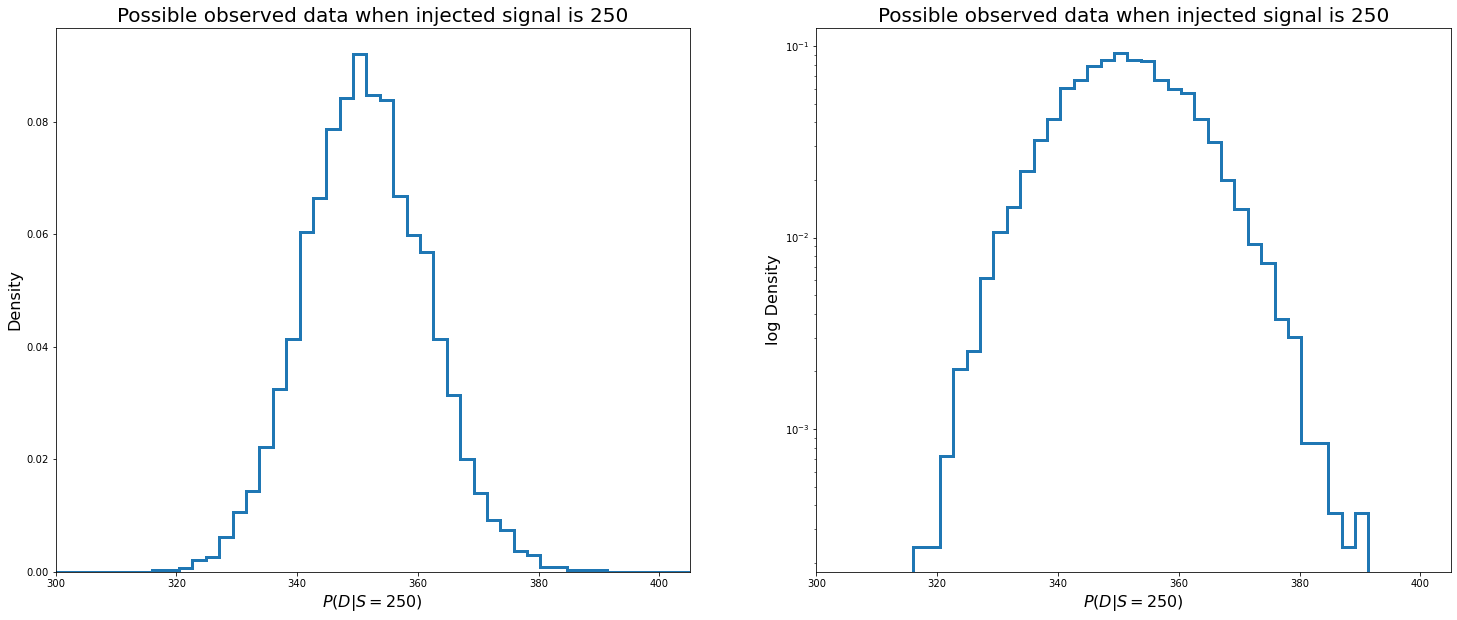

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
for ax in axes:
    ax.stairs(Psd.T[85]/sum(Psd.T[85]), temp, lw=3)
    ax.set_xlim(300, 405)
    ax.set_title('Possible observed data when injected signal is 250')
    ax.set_xlabel(r'$P(D|S=250)$')
axes[1].set_yscale('log')
axes[0].set_ylabel('Density')
axes[1].set_ylabel('log Density');

These match well with the histograms of $P(D|S=250)$ from Problem 2.

### Part (c)

Now we will do the reverse and look at the 1D histogram of the possible injected signal strengths for a chosen measured data value. Let's take $P(S|D=250)$ for this example, for the sake of consistency.

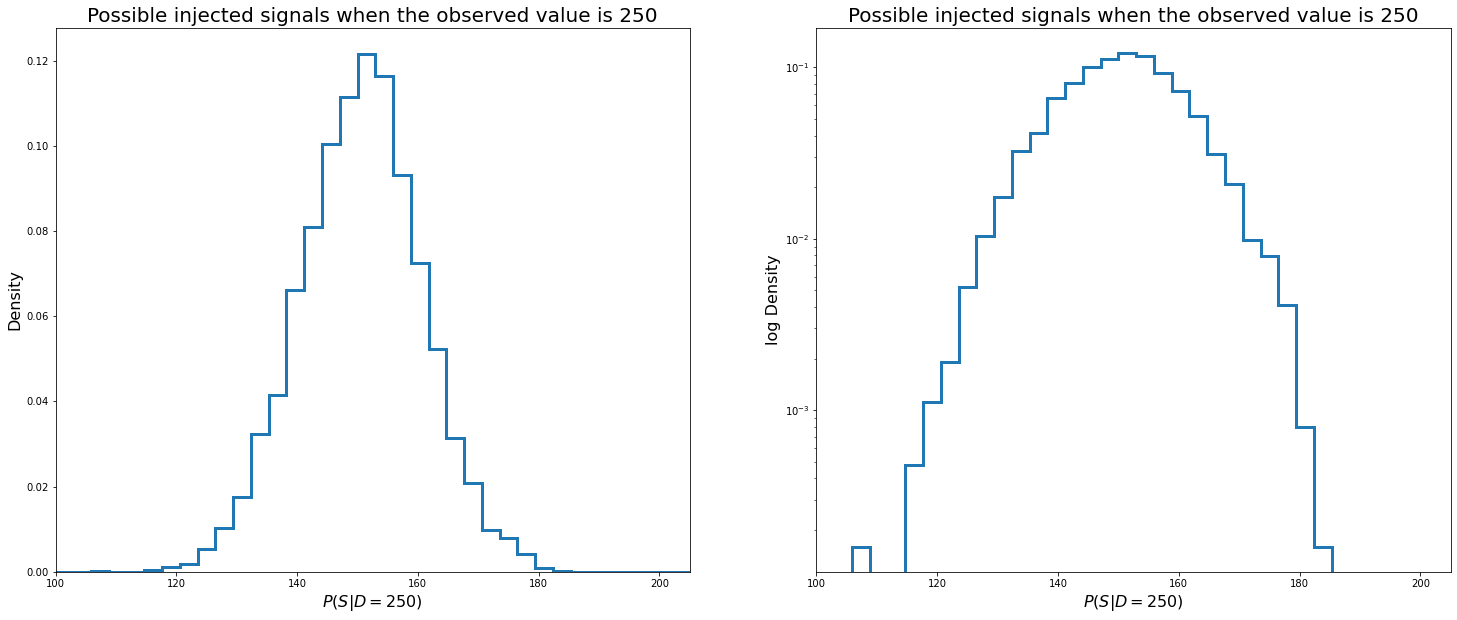

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
for ax in axes:
    ax.stairs(Psd[90]/sum(Psd[90]), temp2, lw=3)
    ax.set_xlim(100, 205)
    ax.set_title('Possible injected signals when the observed value is 250')
    ax.set_xlabel(r'$P(S|D=250)$')
axes[1].set_yscale('log')
axes[0].set_ylabel('Density')
axes[1].set_ylabel('log Density');

If we measure a value of exactly 250, these histograms show us the probability density of possible injected signals we may have used.

### Part (d)

We will now determine the limits of the $1\sigma$ confidence interval, in much the same way that we found the $5\sigma$ confidence interval in Problem 1.

In [12]:
sig_250 = Psd[90]

prob_1s = stats.norm.cdf(1.0)

prob = [sig_250[i] * temp2[i] for i in range(len(sig_250))]
prob = prob / sum(prob)

n = 0
cdf = 0.0
in_low_tail = True

for i in range(len(prob)):
    n += 1
    cdf += prob[i]
    if in_low_tail == True and cdf >= 1.0 - prob_1s:
        in_low_tail = False
        minus_1s = temp2[i]
        print(temp2[i])
    if cdf >= prob_1s:
        plus_1s = temp2[i]
        print(temp2[i])
        break

138.23529411764707
158.82352941176472


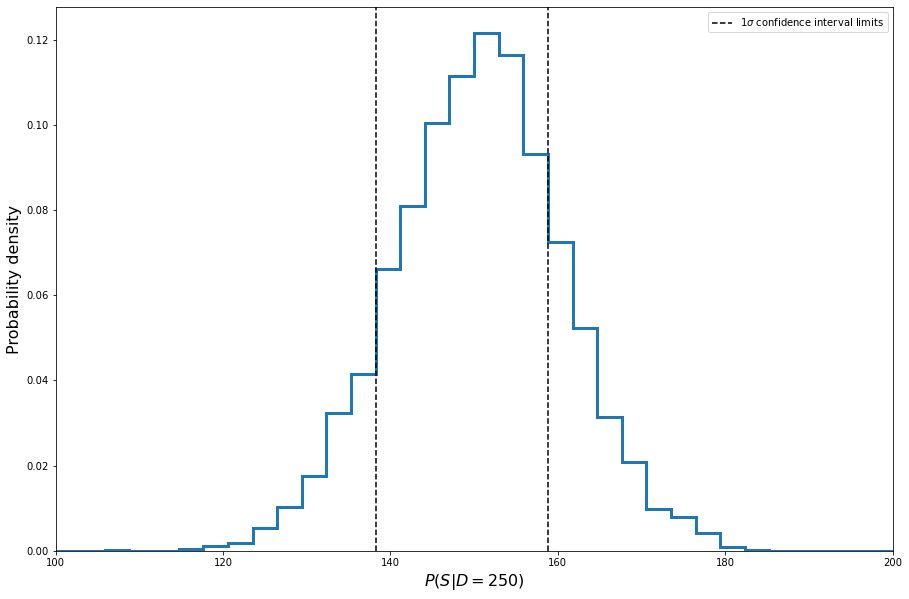

In [13]:
fig, ax = plt.subplots(1, 1)
ax.stairs(Psd[90]/sum(Psd[90]), temp2, lw=3)
ax.axvline(minus_1s, c='k', ls='--', label=r'$1\sigma$ confidence interval limits')
ax.axvline(plus_1s, c='k', ls='--')
ax.set_xlim(100, 200)
ax.set_xlabel(r'$P(S|D=250)$')
ax.set_ylabel('Probability density')
ax.legend(loc=0);

We find that including uncertainty, we can write the injected signal strength as $150.0 \pm 8.8$.

### Part (e)

The $1\sigma$ confidence interval we found in Part (d) is biased, but symmetric. It is biased because a measured value of 250 gave us a distribution of possible injected signals with an expectation value of 150. As at every stage of this lab, there is an offset of 100. There is symmetry here, because the limits of the $1\sigma$ confidence interval are equidistant from the mean (*i.e.*, we can write down the injected signal strength as $\mu \pm \sigma$ as opposed to $\mu^{+X}_{-Y}$. The confidence interval is roughly symmetric about the mean because we are essentially working with a Poisson distribution with high mean, which as we know tends toward a Gaussian distribution, which is symmetric.